<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Thu Feb  8 20:28:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:A8:00.0 Off |                    0 |
| N/A   29C    P0              48W / 350W |      4MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [8]:
%%time

######### Generating SINN training data by solving SDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad



###### Parameters 
mag=1              # Magnitude of the coupling
beta=1             # Inverse temperature 
alpha=1            
gamma=1            # Anharmonic potential U(x)=alpha/2* x^2  + gamma/4* x^4
N=100              # Total number of oscillators in the chain 
N_mid=int(N/2)     # Coordinate of the center CG-oscillator 
dt=0.01 
delta_t=0.5
batch = 400
sec_length = 400

Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]



# (q25,q75)
q25_store = np.zeros([t_store.size+1,batch])    
q75_store = np.zeros([t_store.size+1,batch])

q=np.zeros((1,length)) 

p1=np.zeros((N,batch))
q1=np.zeros((N,batch))
p0=np.zeros((N,batch))
q0=np.zeros((N,batch))

# solve SDE

j=1
for i in range(1,length):
    q1=q0+dt*(p0-np.roll(p0,1,axis=0))
    p1=(1-mag*dt)*p0+dt*alpha*(np.roll(q0,-1,axis=0)-q0)+dt*gamma*(np.roll(q0,-1,axis=0)**3-q0**3)+np.sqrt(2*dt*gamma/beta)*np.random.randn(N,batch)
    if i % gap ==0:        
        q25_store[j,:]= np.sum(q1[0:25,:], axis=0)
        q75_store[j,:]= np.sum(q1[0:75,:], axis=0)
        j=j+1
    p0=p1
    q0=q1
                                
Toss=int(t_store.size/4)
q25_store=q25_store[Toss:-1,:] 
q75_store=q75_store[Toss:-1,:] 

1000.0
CPU times: user 9min 7s, sys: 16.8 ms, total: 9min 7s
Wall time: 9min 8s


Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$')

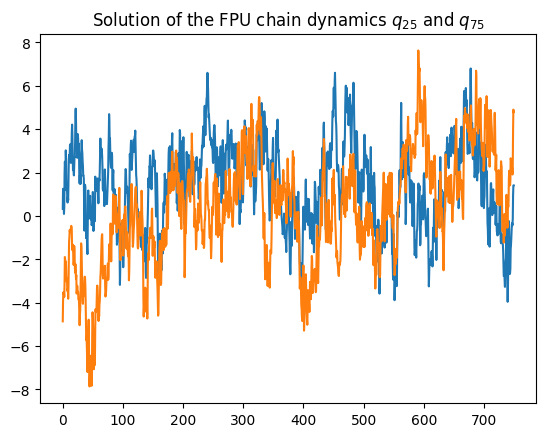

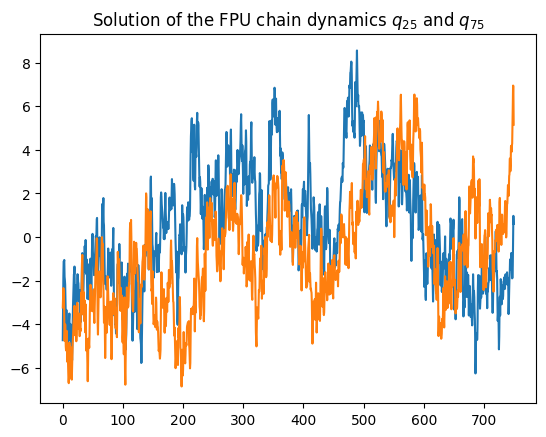

In [9]:
plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0])
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,1])
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,1])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


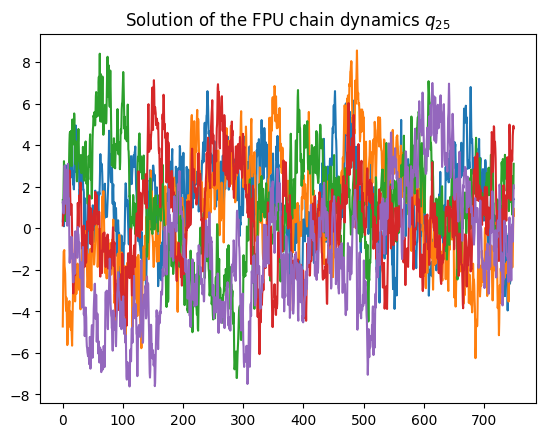

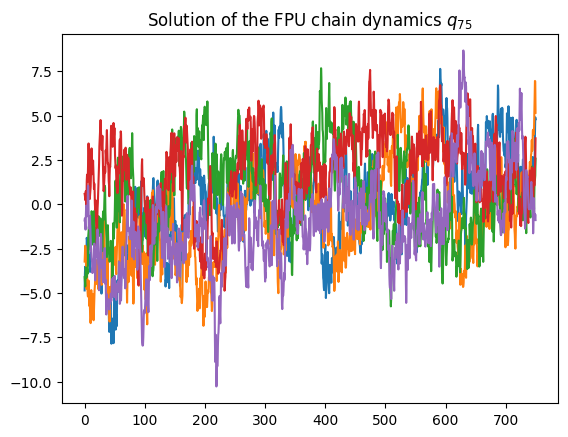

In [10]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{75}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj25 = q25_store[0:sec_length,:]
Traj75 = q75_store[0:sec_length,:]
print(ini.shape, Traj25.shape, Traj75.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj25
Traj[:,:,1] = Traj75
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [11]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [12]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


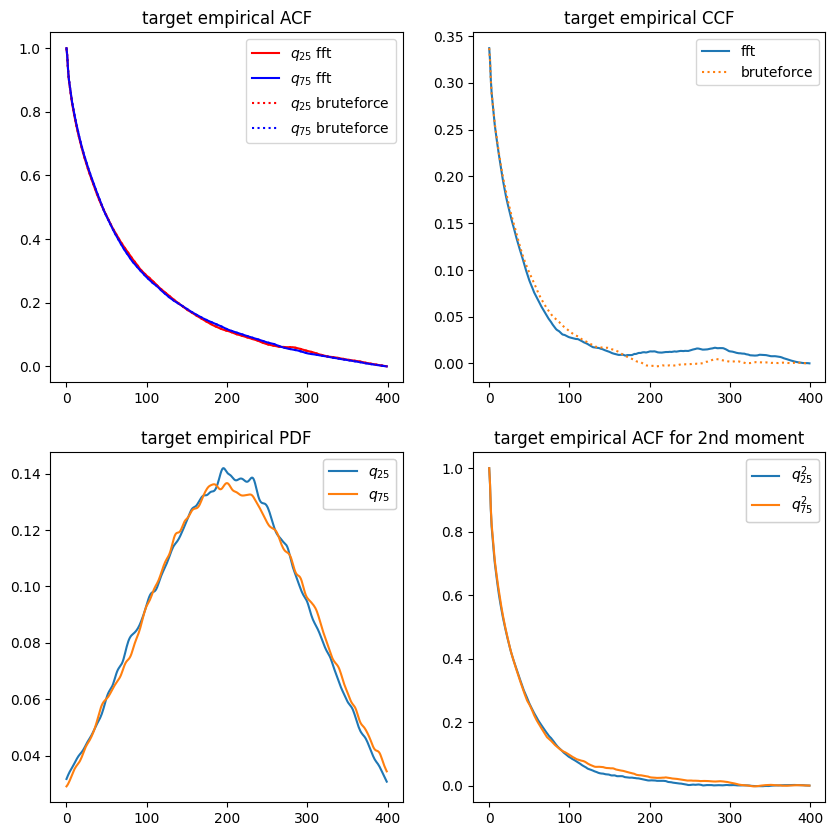

In [13]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{25}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{75}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{25}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{75}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{25}$',r'$q_{75}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{25}^2$',r'$q_{75}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

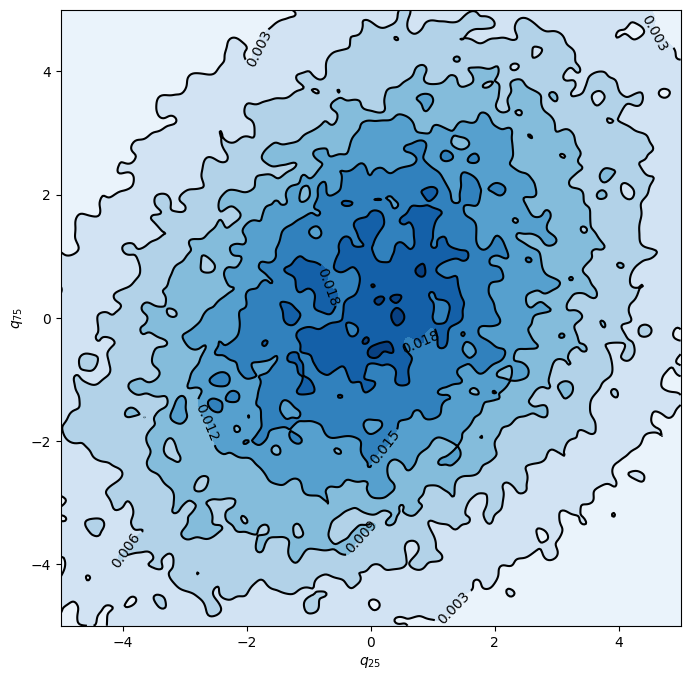

In [14]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{25}$')
ax.set_ylabel(r'$q_{75}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

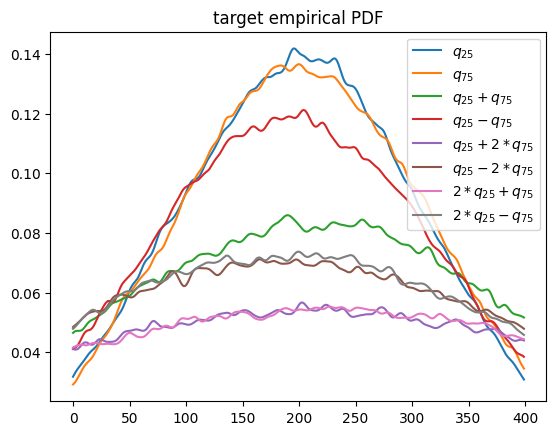

In [15]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{25}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{25}-q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{25}+2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{25}-2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{25}-q_{75}$')
plt.legend()
plt.title('target empirical PDF')

In [16]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0
        self.time = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2

    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = loss_acf_fft(prediction)+ loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break

        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        self.time = elapsed
        print('Training time: %.2f' % elapsed)
        avg_time = elapsed/self.iter
        print('Training time per iteration: %.2f' % avg_time)
        print('Number of Iterations:%d' %self.iter)

In [17]:
model_type = 1

In [18]:
### Defining SINN model
net = SINN(2, 75, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model = Model(net=net)
model.train()

[0]-th step loss: 0.7060, 0.6973, acf: 0.07473, ccf: 0.00819, pdf: 0.29048, pdf2: 0.29539, acf2: 0.02852
[50]-th step loss: 0.0342, 0.0375, acf: 0.01463, ccf: 0.00279, pdf: 0.00979, pdf2: 0.00358, acf2: 0.00666
[100]-th step loss: 0.0253, 0.0189, acf: 0.00224, ccf: 0.00167, pdf: 0.00559, pdf2: 0.00376, acf2: 0.00561
[150]-th step loss: 0.0195, 0.0182, acf: 0.00687, ccf: 0.00174, pdf: 0.00526, pdf2: 0.00334, acf2: 0.00102
[200]-th step loss: 0.0412, 0.0388, acf: 0.01387, ccf: 0.00706, pdf: 0.00790, pdf2: 0.00654, acf2: 0.00344
[250]-th step loss: 0.0328, 0.0304, acf: 0.00541, ccf: 0.01283, pdf: 0.00664, pdf2: 0.00379, acf2: 0.00171
[300]-th step loss: 0.0187, 0.0336, acf: 0.00952, ccf: 0.01908, pdf: 0.00149, pdf2: 0.00287, acf2: 0.00066
[350]-th step loss: 0.0119, 0.0091, acf: 0.00422, ccf: 0.00107, pdf: 0.00100, pdf2: 0.00197, acf2: 0.00082
[400]-th step loss: 0.0126, 0.0138, acf: 0.00560, ccf: 0.00369, pdf: 0.00256, pdf2: 0.00150, acf2: 0.00041
[450]-th step loss: 0.0373, 0.0350, acf:

In [19]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [20]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [21]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [22]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

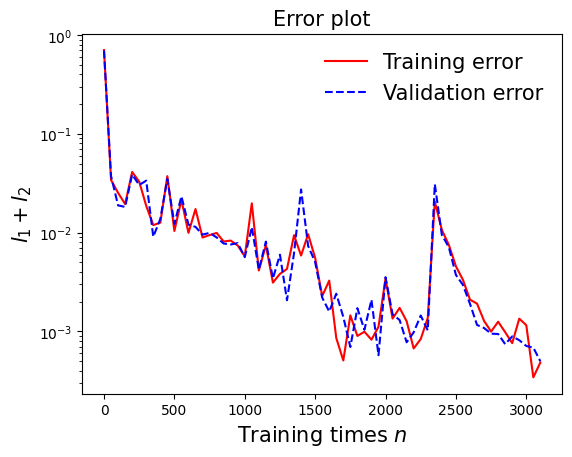

In [23]:
draw_loss(model)

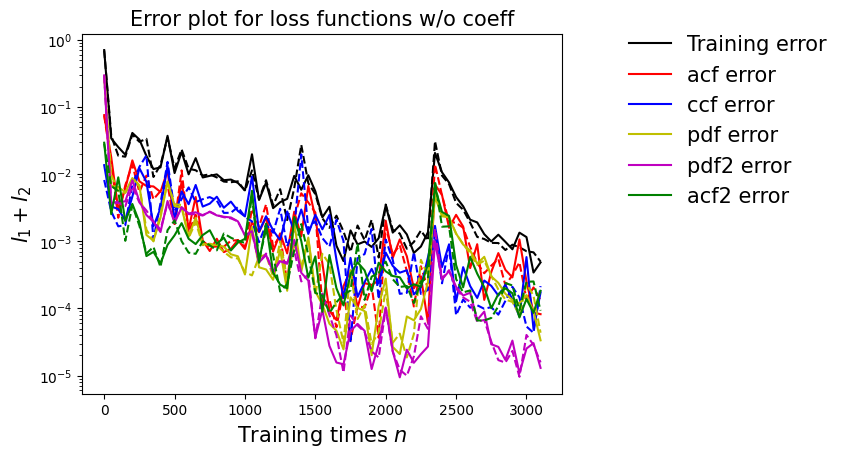

In [24]:
draw_errors(model)

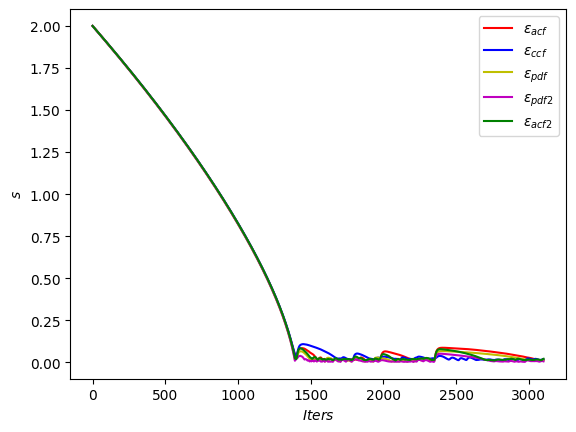

In [25]:
draw_adaptive_w(model)

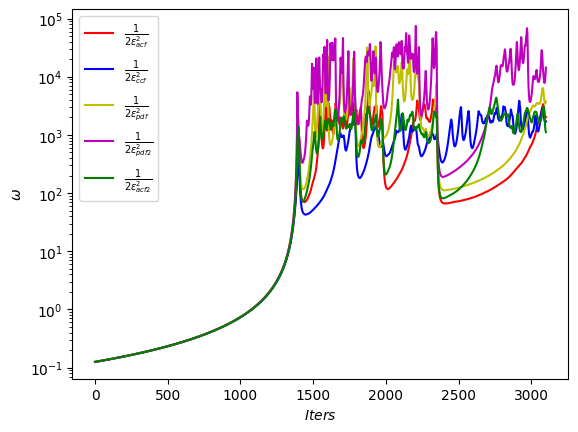

In [26]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [27]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [28]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [29]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{25}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{25}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{25}+2q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{25}-2q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{25}+2q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{25}-2q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [30]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{25}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{75}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [31]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [32]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [33]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{25}$')
    plt.ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

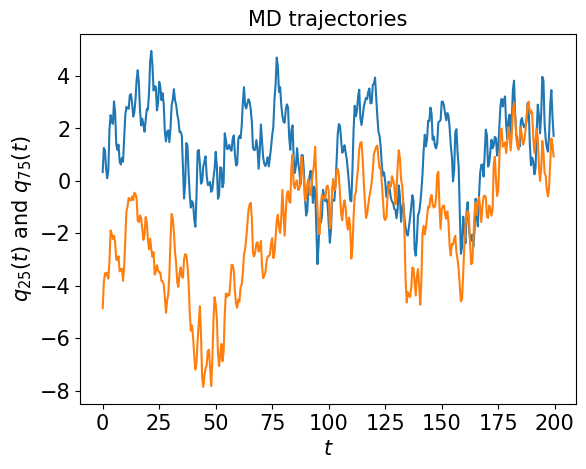

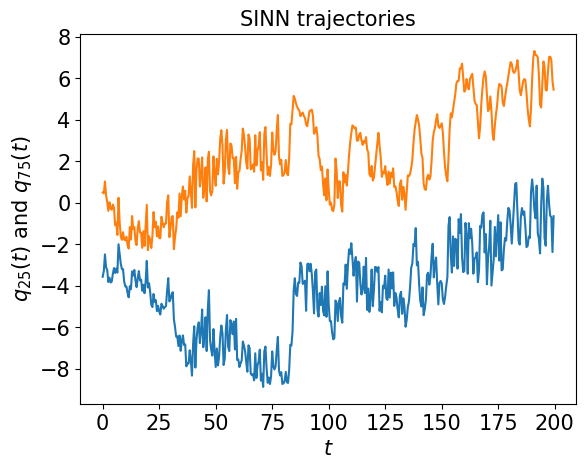

In [34]:
test1(model)

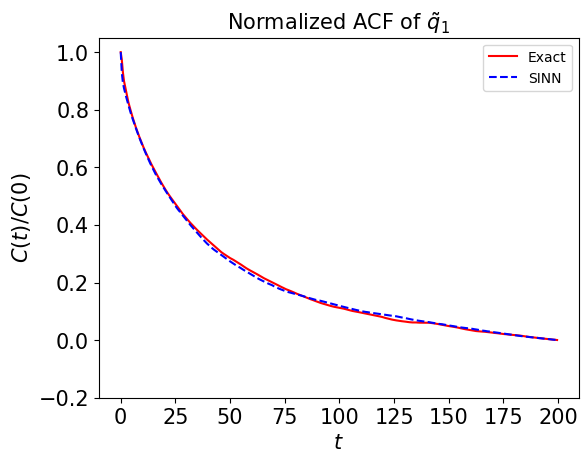

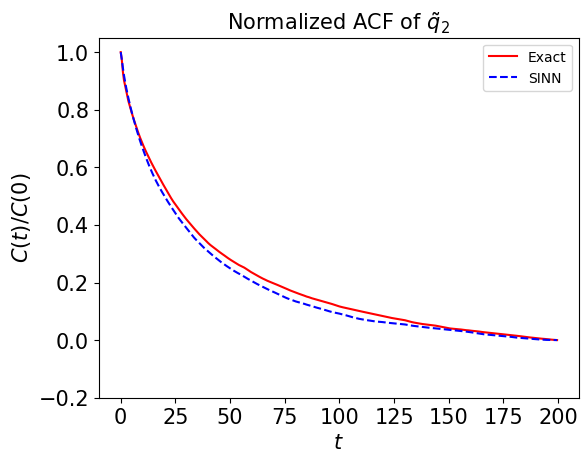

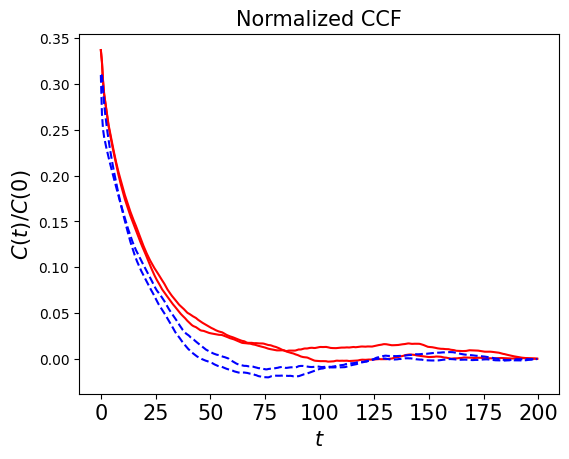

In [35]:
test2(model)

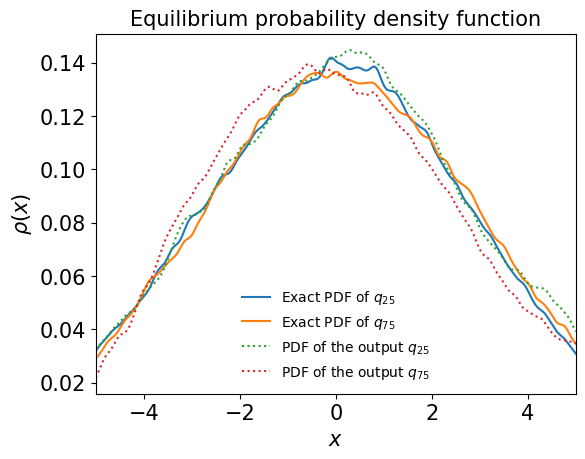

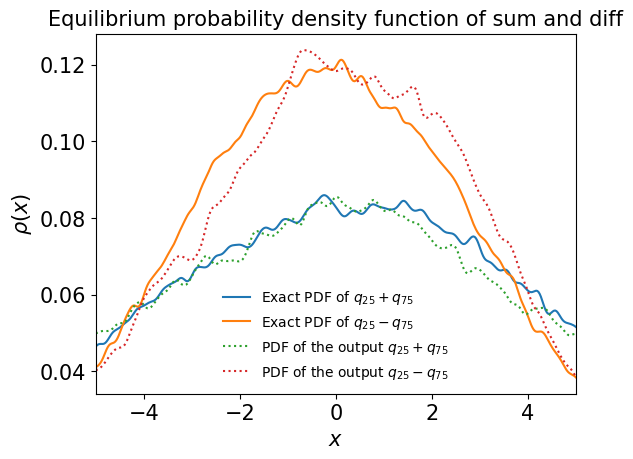

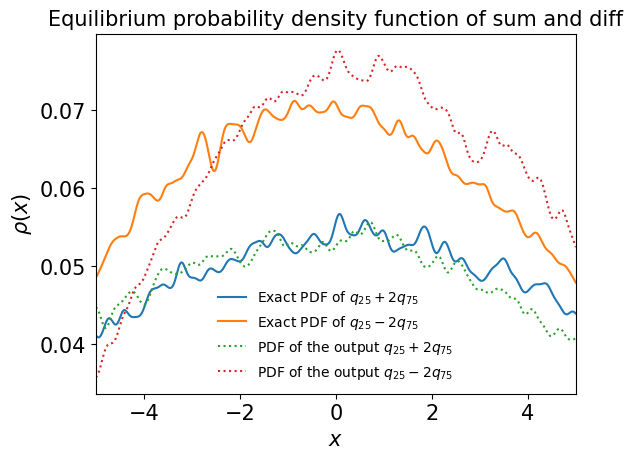

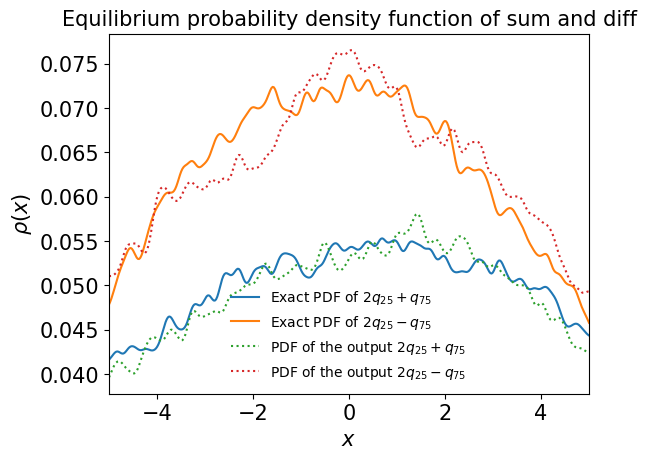

In [36]:
test3(model)

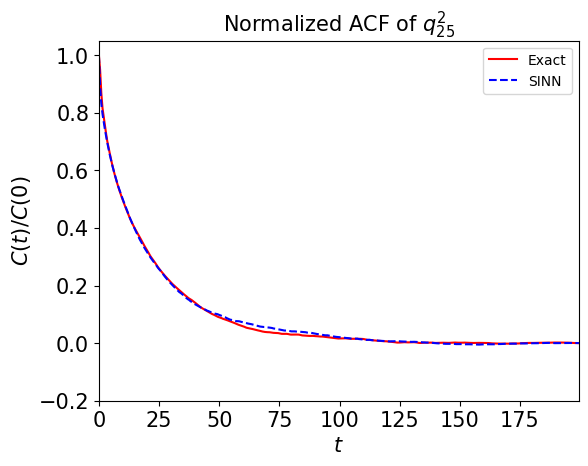

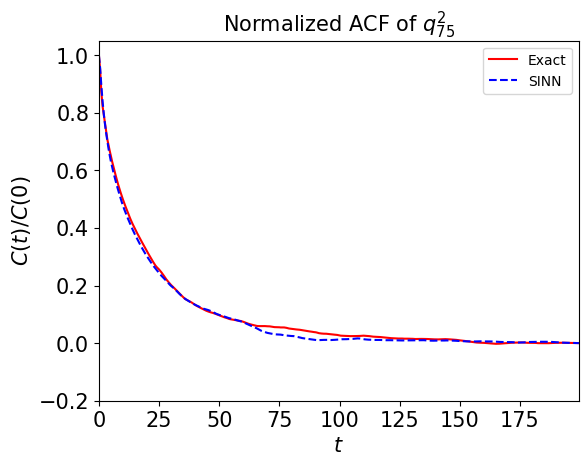

In [37]:
test4(model)

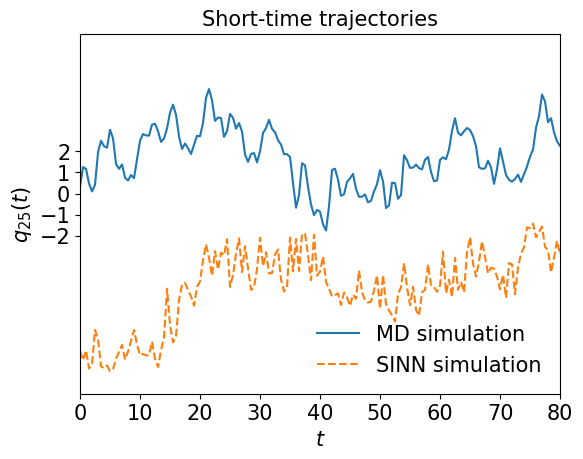

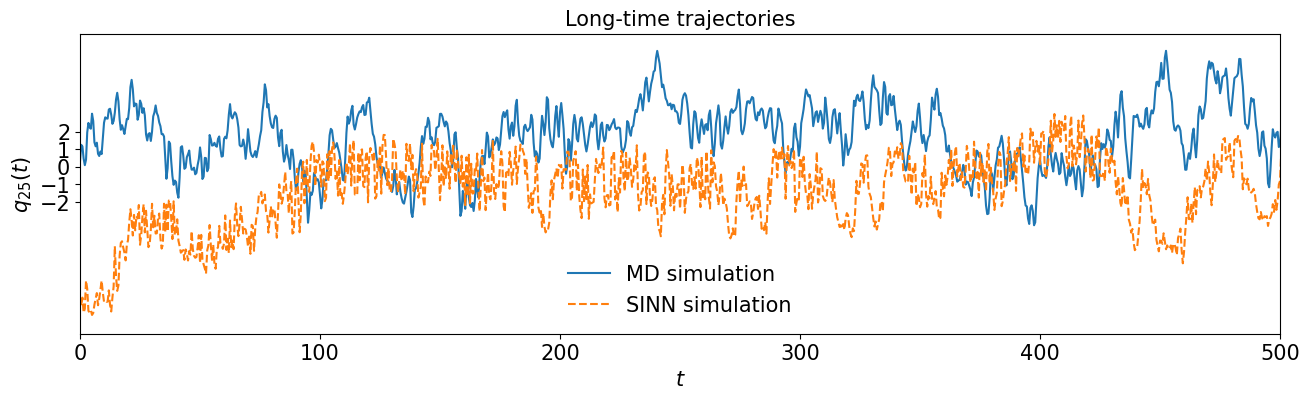

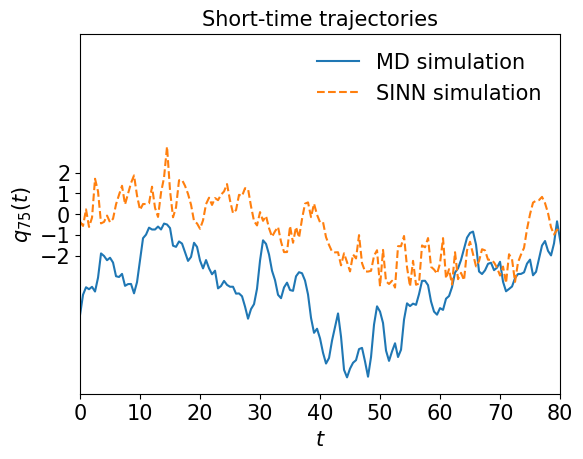

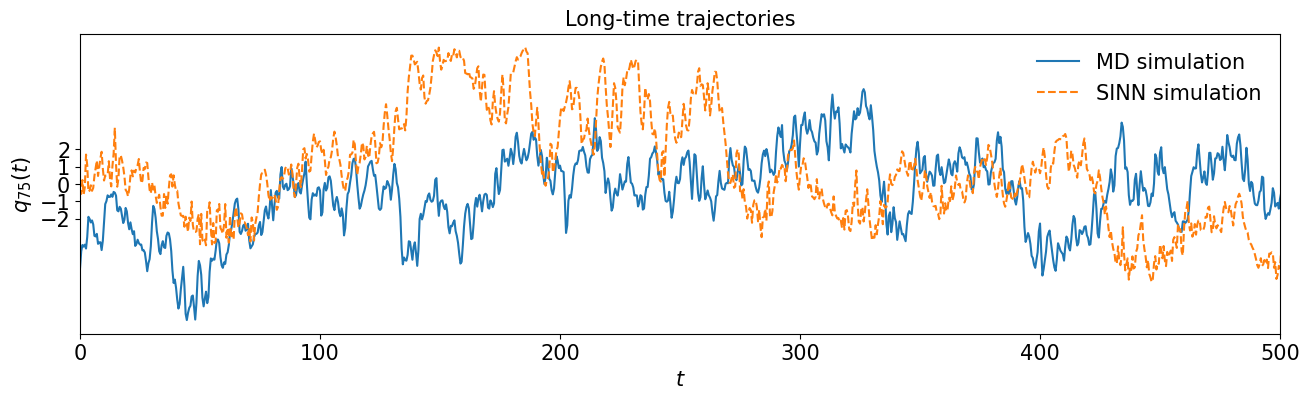

In [38]:
test5(model)

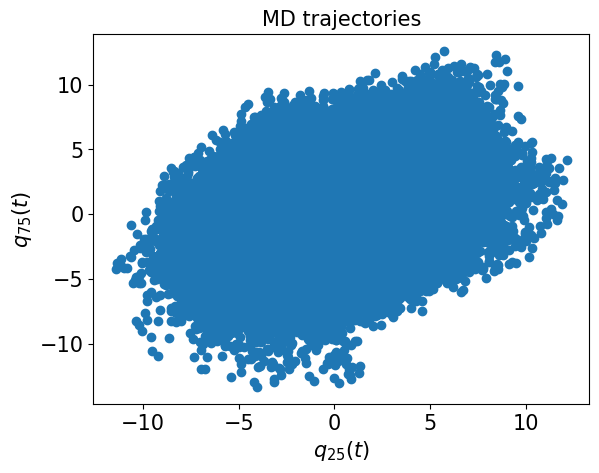

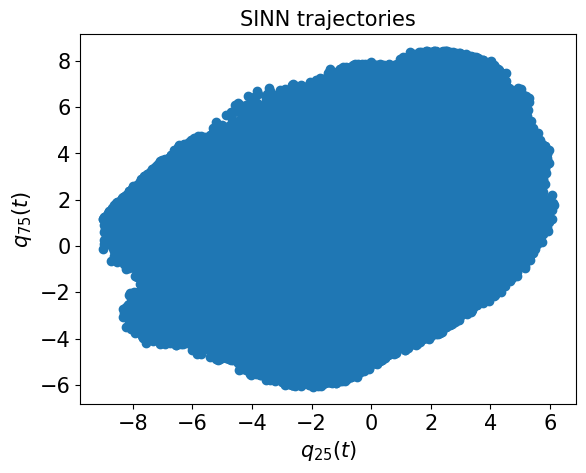

In [39]:
test6(model)

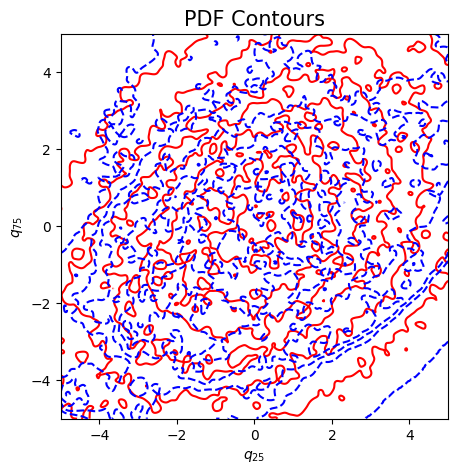

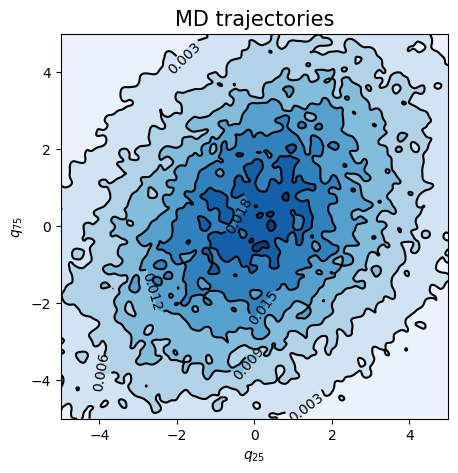

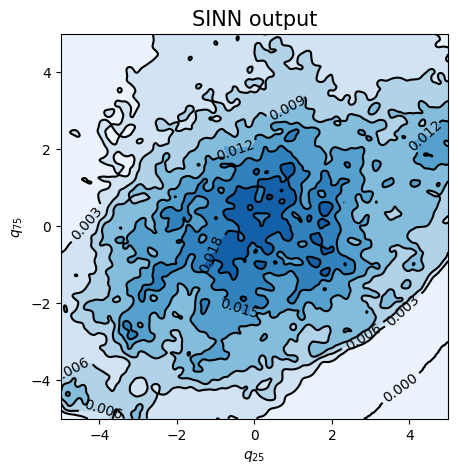

In [40]:
test7(model)

In [41]:
### Defining SINN model
net1 = SINN(2, 75, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model1 = Model(net=net1)
model1.train()

[0]-th step loss: 0.7001, 0.6931, acf: 0.07494, ccf: 0.00401, pdf: 0.29032, pdf2: 0.29510, acf2: 0.02878
[50]-th step loss: 0.0689, 0.0735, acf: 0.03534, ccf: 0.01389, pdf: 0.01075, pdf2: 0.00839, acf2: 0.00518
[100]-th step loss: 0.0282, 0.0262, acf: 0.01057, ccf: 0.00577, pdf: 0.00499, pdf2: 0.00190, acf2: 0.00301
[150]-th step loss: 0.1322, 0.1307, acf: 0.03431, ccf: 0.06689, pdf: 0.02033, pdf2: 0.00388, acf2: 0.00532
[200]-th step loss: 0.0510, 0.0470, acf: 0.01870, ccf: 0.00337, pdf: 0.01623, pdf2: 0.00690, acf2: 0.00179
[250]-th step loss: 0.0364, 0.0393, acf: 0.01242, ccf: 0.01275, pdf: 0.00813, pdf2: 0.00407, acf2: 0.00189
[300]-th step loss: 0.1172, 0.1167, acf: 0.06798, ccf: 0.01214, pdf: 0.01126, pdf2: 0.00263, acf2: 0.02264
[350]-th step loss: 0.0393, 0.0396, acf: 0.01549, ccf: 0.01293, pdf: 0.00771, pdf2: 0.00259, acf2: 0.00086
[400]-th step loss: 0.0291, 0.0611, acf: 0.01551, ccf: 0.02139, pdf: 0.01896, pdf2: 0.00326, acf2: 0.00198
[450]-th step loss: 0.0134, 0.0133, acf:

[3850]-th step loss: 0.0345, 0.0267, acf: 0.02606, ccf: 0.00012, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00051
[3900]-th step loss: 0.0305, 0.0230, acf: 0.02237, ccf: 0.00035, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00028
[3950]-th step loss: 0.0378, 0.0372, acf: 0.03063, ccf: 0.00070, pdf: 0.00051, pdf2: 0.00019, acf2: 0.00515
[4000]-th step loss: 0.0238, 0.0238, acf: 0.02261, ccf: 0.00013, pdf: 0.00032, pdf2: 0.00009, acf2: 0.00067
[4050]-th step loss: 0.0205, 0.0205, acf: 0.01967, ccf: 0.00012, pdf: 0.00022, pdf2: 0.00007, acf2: 0.00045
[4100]-th step loss: 0.0222, 0.0191, acf: 0.01852, ccf: 0.00014, pdf: 0.00013, pdf2: 0.00003, acf2: 0.00026
[4150]-th step loss: 0.0547, 0.0534, acf: 0.04345, ccf: 0.00118, pdf: 0.00347, pdf2: 0.00060, acf2: 0.00473
[4200]-th step loss: 0.0378, 0.0364, acf: 0.03258, ccf: 0.00068, pdf: 0.00177, pdf2: 0.00030, acf2: 0.00104
[4250]-th step loss: 0.0278, 0.0300, acf: 0.02749, ccf: 0.00036, pdf: 0.00146, pdf2: 0.00022, acf2: 0.00042
[4300]-th step loss: 0.0337,

[7650]-th step loss: 0.0245, 0.0212, acf: 0.02029, ccf: 0.00010, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00078
[7700]-th step loss: 0.0239, 0.0228, acf: 0.02222, ccf: 0.00006, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00052
[7750]-th step loss: 0.0193, 0.0198, acf: 0.01932, ccf: 0.00010, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00034
[7800]-th step loss: 0.0267, 0.0243, acf: 0.02359, ccf: 0.00009, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00059
[7850]-th step loss: 0.0228, 0.0220, acf: 0.02118, ccf: 0.00008, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00072
[7900]-th step loss: 0.0250, 0.0244, acf: 0.02397, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00039
[7950]-th step loss: 0.0215, 0.0235, acf: 0.02312, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00035
[8000]-th step loss: 0.0285, 0.0258, acf: 0.02493, ccf: 0.00016, pdf: 0.00014, pdf2: 0.00003, acf2: 0.00051
[8050]-th step loss: 0.0231, 0.0226, acf: 0.02187, ccf: 0.00009, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00059
[8100]-th step loss: 0.0236,

[11450]-th step loss: 0.0269, 0.0267, acf: 0.02628, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00034
[11500]-th step loss: 0.0242, 0.0230, acf: 0.02269, ccf: 0.00007, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00023
[11550]-th step loss: 0.0236, 0.0253, acf: 0.02499, ccf: 0.00007, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00021
[11600]-th step loss: 0.0213, 0.0216, acf: 0.02134, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00015
[11650]-th step loss: 0.0245, 0.0282, acf: 0.02773, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00041
[11700]-th step loss: 0.0242, 0.0263, acf: 0.02597, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00024
[11750]-th step loss: 0.0292, 0.0252, acf: 0.02465, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00051
[11800]-th step loss: 0.0215, 0.0240, acf: 0.02340, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00054
[11850]-th step loss: 0.0188, 0.0195, acf: 0.01919, ccf: 0.00008, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00020
[11900]-th step los

[15250]-th step loss: 0.0183, 0.0171, acf: 0.01690, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00017
[15300]-th step loss: 0.0192, 0.0182, acf: 0.01788, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00023
[15350]-th step loss: 0.0167, 0.0173, acf: 0.01695, ccf: 0.00007, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00026
[15400]-th step loss: 0.0174, 0.0185, acf: 0.01827, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00017
[15450]-th step loss: 0.0181, 0.0155, acf: 0.01489, ccf: 0.00008, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00053
[15500]-th step loss: 0.0455, 0.0415, acf: 0.03232, ccf: 0.00061, pdf: 0.00444, pdf2: 0.00224, acf2: 0.00186
[15550]-th step loss: 0.0268, 0.0267, acf: 0.02193, ccf: 0.00026, pdf: 0.00293, pdf2: 0.00133, acf2: 0.00023
[15600]-th step loss: 0.0273, 0.0261, acf: 0.02262, ccf: 0.00013, pdf: 0.00240, pdf2: 0.00084, acf2: 0.00011
[15650]-th step loss: 0.0244, 0.0238, acf: 0.02093, ccf: 0.00007, pdf: 0.00203, pdf2: 0.00061, acf2: 0.00011
[15700]-th step los

[19050]-th step loss: 0.0206, 0.0191, acf: 0.01893, ccf: 0.00004, pdf: 0.00002, pdf2: 0.00000, acf2: 0.00014
[19100]-th step loss: 0.0169, 0.0164, acf: 0.01617, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00013
[19150]-th step loss: 0.0169, 0.0169, acf: 0.01673, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00011
[19200]-th step loss: 0.0227, 0.0182, acf: 0.01804, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00015
[19250]-th step loss: 0.0226, 0.0209, acf: 0.02069, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00013
[19300]-th step loss: 0.0232, 0.0190, acf: 0.01882, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00018
[19350]-th step loss: 0.0152, 0.0144, acf: 0.01419, ccf: 0.00004, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00014
[19400]-th step loss: 0.0164, 0.0167, acf: 0.01652, ccf: 0.00005, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00014
[19450]-th step loss: 0.0212, 0.0198, acf: 0.01963, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00015
[19500]-th step los

In [42]:
### Defining SINN model
net2 = SINN(2, 75, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model2 = Model(net=net2)
model2.train()

[0]-th step loss: 0.6961, 0.6914, acf: 0.07319, ccf: 0.00349, pdf: 0.29066, pdf2: 0.29677, acf2: 0.02730
[50]-th step loss: 0.0719, 0.0715, acf: 0.01441, ccf: 0.02925, pdf: 0.01260, pdf2: 0.01335, acf2: 0.00185
[100]-th step loss: 0.0272, 0.0305, acf: 0.00969, ccf: 0.00649, pdf: 0.00709, pdf2: 0.00529, acf2: 0.00194
[150]-th step loss: 0.0320, 0.0321, acf: 0.00528, ccf: 0.01672, pdf: 0.00373, pdf2: 0.00294, acf2: 0.00339
[200]-th step loss: 0.0192, 0.0176, acf: 0.00311, ccf: 0.00705, pdf: 0.00341, pdf2: 0.00153, acf2: 0.00253
[250]-th step loss: 0.0155, 0.0169, acf: 0.00158, ccf: 0.00527, pdf: 0.00356, pdf2: 0.00158, acf2: 0.00490
[300]-th step loss: 0.0342, 0.0292, acf: 0.01809, ccf: 0.00347, pdf: 0.00343, pdf2: 0.00114, acf2: 0.00303
[350]-th step loss: 0.0155, 0.0167, acf: 0.00655, ccf: 0.00131, pdf: 0.00323, pdf2: 0.00118, acf2: 0.00439
[400]-th step loss: 0.0119, 0.0123, acf: 0.00178, ccf: 0.00120, pdf: 0.00459, pdf2: 0.00117, acf2: 0.00352
[450]-th step loss: 0.0161, 0.0149, acf:

In [43]:
### Defining SINN model
net3 = SINN(2, 75, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model3 = Model(net=net3)
model3.train()

[0]-th step loss: 0.7007, 0.6931, acf: 0.07387, ccf: 0.00401, pdf: 0.29064, pdf2: 0.29669, acf2: 0.02785
[50]-th step loss: 0.0788, 0.0808, acf: 0.02767, ccf: 0.02030, pdf: 0.01780, pdf2: 0.01004, acf2: 0.00501
[100]-th step loss: 0.0972, 0.1002, acf: 0.03553, ccf: 0.01070, pdf: 0.03824, pdf2: 0.01091, acf2: 0.00482
[150]-th step loss: 0.0620, 0.0549, acf: 0.01952, ccf: 0.01237, pdf: 0.01541, pdf2: 0.00702, acf2: 0.00061
[200]-th step loss: 0.0585, 0.0527, acf: 0.03479, ccf: 0.00487, pdf: 0.00525, pdf2: 0.00225, acf2: 0.00554
[250]-th step loss: 0.0428, 0.0442, acf: 0.03400, ccf: 0.00097, pdf: 0.00424, pdf2: 0.00193, acf2: 0.00307
[300]-th step loss: 0.0297, 0.0286, acf: 0.01105, ccf: 0.00532, pdf: 0.00513, pdf2: 0.00213, acf2: 0.00502
[350]-th step loss: 0.0170, 0.0176, acf: 0.00915, ccf: 0.00187, pdf: 0.00339, pdf2: 0.00130, acf2: 0.00188
[400]-th step loss: 0.1952, 0.1769, acf: 0.05130, ccf: 0.00819, pdf: 0.10101, pdf2: 0.00438, acf2: 0.01206
[450]-th step loss: 0.0406, 0.0403, acf:

[3850]-th step loss: 0.0122, 0.0110, acf: 0.00014, ccf: 0.00007, pdf: 0.00519, pdf2: 0.00240, acf2: 0.00324
[3900]-th step loss: 0.0113, 0.0120, acf: 0.00048, ccf: 0.00053, pdf: 0.00531, pdf2: 0.00246, acf2: 0.00317
[3950]-th step loss: 0.0121, 0.0122, acf: 0.00009, ccf: 0.00012, pdf: 0.00509, pdf2: 0.00239, acf2: 0.00452
[4000]-th step loss: 0.0129, 0.0122, acf: 0.00025, ccf: 0.00007, pdf: 0.00513, pdf2: 0.00235, acf2: 0.00437
[4050]-th step loss: 0.1308, 0.1311, acf: 0.07654, ccf: 0.00372, pdf: 0.00952, pdf2: 0.01143, acf2: 0.02992
[4100]-th step loss: 0.0767, 0.0765, acf: 0.04173, ccf: 0.00257, pdf: 0.00952, pdf2: 0.00946, acf2: 0.01323
[4150]-th step loss: 0.0648, 0.0655, acf: 0.03702, ccf: 0.00287, pdf: 0.00952, pdf2: 0.00707, acf2: 0.00902
[4200]-th step loss: 0.0385, 0.0359, acf: 0.01787, ccf: 0.00138, pdf: 0.00952, pdf2: 0.00533, acf2: 0.00178
[4250]-th step loss: 0.0277, 0.0314, acf: 0.01691, ccf: 0.00037, pdf: 0.00949, pdf2: 0.00405, acf2: 0.00056
[4300]-th step loss: 0.0259,

[7650]-th step loss: 0.0186, 0.0183, acf: 0.01097, ccf: 0.00009, pdf: 0.00504, pdf2: 0.00208, acf2: 0.00012
[7700]-th step loss: 0.0179, 0.0171, acf: 0.00946, ccf: 0.00006, pdf: 0.00549, pdf2: 0.00193, acf2: 0.00012
[7750]-th step loss: 0.0172, 0.0155, acf: 0.00803, ccf: 0.00006, pdf: 0.00549, pdf2: 0.00178, acf2: 0.00012
[7800]-th step loss: 0.0177, 0.0176, acf: 0.00928, ccf: 0.00013, pdf: 0.00622, pdf2: 0.00184, acf2: 0.00016
[7850]-th step loss: 0.0175, 0.0158, acf: 0.00805, ccf: 0.00016, pdf: 0.00564, pdf2: 0.00182, acf2: 0.00012
[7900]-th step loss: 0.0197, 0.0175, acf: 0.00941, ccf: 0.00024, pdf: 0.00589, pdf2: 0.00178, acf2: 0.00014
[7950]-th step loss: 0.0168, 0.0160, acf: 0.00846, ccf: 0.00007, pdf: 0.00552, pdf2: 0.00185, acf2: 0.00011
[8000]-th step loss: 0.0161, 0.0152, acf: 0.00753, ccf: 0.00028, pdf: 0.00537, pdf2: 0.00188, acf2: 0.00014
[8050]-th step loss: 0.0144, 0.0155, acf: 0.00796, ccf: 0.00013, pdf: 0.00557, pdf2: 0.00177, acf2: 0.00010
[8100]-th step loss: 0.0186,

[11450]-th step loss: 0.0012, 0.0010, acf: 0.00012, ccf: 0.00026, pdf: 0.00030, pdf2: 0.00003, acf2: 0.00025
[11500]-th step loss: 0.0008, 0.0006, acf: 0.00020, ccf: 0.00013, pdf: 0.00006, pdf2: 0.00004, acf2: 0.00015
[11550]-th step loss: 0.0005, 0.0004, acf: 0.00008, ccf: 0.00012, pdf: 0.00005, pdf2: 0.00004, acf2: 0.00010
Training finished
Training time: 1011.91
Training time per iteration: 0.09
Number of Iterations:11551


In [44]:
### Defining SINN model
net4 = SINN(2, 75, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model4 = Model(net=net4)
model4.train()

[0]-th step loss: 0.7078, 0.6962, acf: 0.07548, ccf: 0.00383, pdf: 0.29078, pdf2: 0.29701, acf2: 0.02910
[50]-th step loss: 0.0523, 0.0460, acf: 0.02090, ccf: 0.00451, pdf: 0.01210, pdf2: 0.00665, acf2: 0.00186
[100]-th step loss: 0.0645, 0.0602, acf: 0.01405, ccf: 0.02741, pdf: 0.01267, pdf2: 0.00351, acf2: 0.00253
[150]-th step loss: 0.0457, 0.0425, acf: 0.01195, ccf: 0.01601, pdf: 0.00834, pdf2: 0.00271, acf2: 0.00348
[200]-th step loss: 0.0746, 0.0756, acf: 0.04259, ccf: 0.00722, pdf: 0.01003, pdf2: 0.00373, acf2: 0.01203
[250]-th step loss: 0.0182, 0.0159, acf: 0.00204, ccf: 0.00035, pdf: 0.00801, pdf2: 0.00430, acf2: 0.00117
[300]-th step loss: 0.0269, 0.0230, acf: 0.00991, ccf: 0.00420, pdf: 0.00411, pdf2: 0.00264, acf2: 0.00208
[350]-th step loss: 0.0102, 0.0114, acf: 0.00285, ccf: 0.00104, pdf: 0.00328, pdf2: 0.00171, acf2: 0.00256
[400]-th step loss: 0.1179, 0.1097, acf: 0.05991, ccf: 0.00576, pdf: 0.00952, pdf2: 0.01729, acf2: 0.01718
[450]-th step loss: 0.0608, 0.0627, acf:

[3850]-th step loss: 0.0255, 0.0329, acf: 0.01900, ccf: 0.00056, pdf: 0.00948, pdf2: 0.00317, acf2: 0.00071
[3900]-th step loss: 0.0279, 0.0311, acf: 0.01725, ccf: 0.00038, pdf: 0.00946, pdf2: 0.00312, acf2: 0.00093
[3950]-th step loss: 0.0270, 0.0307, acf: 0.01793, ccf: 0.00010, pdf: 0.00936, pdf2: 0.00300, acf2: 0.00033
[4000]-th step loss: 0.0254, 0.0300, acf: 0.01650, ccf: 0.00034, pdf: 0.00919, pdf2: 0.00340, acf2: 0.00055
[4050]-th step loss: 0.0333, 0.0319, acf: 0.01924, ccf: 0.00017, pdf: 0.00921, pdf2: 0.00282, acf2: 0.00047
[4100]-th step loss: 0.0304, 0.0313, acf: 0.01861, ccf: 0.00025, pdf: 0.00921, pdf2: 0.00280, acf2: 0.00048
[4150]-th step loss: 0.0248, 0.0279, acf: 0.01516, ccf: 0.00018, pdf: 0.00926, pdf2: 0.00277, acf2: 0.00055
[4200]-th step loss: 0.0265, 0.0284, acf: 0.01574, ccf: 0.00025, pdf: 0.00926, pdf2: 0.00279, acf2: 0.00033
[4250]-th step loss: 0.0293, 0.0303, acf: 0.01774, ccf: 0.00013, pdf: 0.00931, pdf2: 0.00282, acf2: 0.00026
[4300]-th step loss: 0.0250,

[7650]-th step loss: 0.0162, 0.0149, acf: 0.00747, ccf: 0.00028, pdf: 0.00525, pdf2: 0.00149, acf2: 0.00043
[7700]-th step loss: 0.0123, 0.0146, acf: 0.00748, ccf: 0.00020, pdf: 0.00519, pdf2: 0.00146, acf2: 0.00030
[7750]-th step loss: 0.0146, 0.0140, acf: 0.00701, ccf: 0.00021, pdf: 0.00513, pdf2: 0.00152, acf2: 0.00017
[7800]-th step loss: 0.0161, 0.0187, acf: 0.01195, ccf: 0.00010, pdf: 0.00485, pdf2: 0.00162, acf2: 0.00017
[7850]-th step loss: 0.0159, 0.0149, acf: 0.00825, ccf: 0.00016, pdf: 0.00494, pdf2: 0.00148, acf2: 0.00012
[7900]-th step loss: 0.0155, 0.0157, acf: 0.00892, ccf: 0.00020, pdf: 0.00493, pdf2: 0.00149, acf2: 0.00012
[7950]-th step loss: 0.0137, 0.0136, acf: 0.00708, ccf: 0.00019, pdf: 0.00472, pdf2: 0.00147, acf2: 0.00019
[8000]-th step loss: 0.0154, 0.0152, acf: 0.00827, ccf: 0.00019, pdf: 0.00502, pdf2: 0.00149, acf2: 0.00019
[8050]-th step loss: 0.0163, 0.0154, acf: 0.00875, ccf: 0.00013, pdf: 0.00477, pdf2: 0.00156, acf2: 0.00021
[8100]-th step loss: 0.0119,

In [45]:
### Defining SINN model
net5 = SINN(2, 75, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model5 = Model(net=net5)
model5.train()

[0]-th step loss: 0.6982, 0.6959, acf: 0.07388, ccf: 0.00534, pdf: 0.29107, pdf2: 0.29769, acf2: 0.02791
[50]-th step loss: 0.0895, 0.0797, acf: 0.02265, ccf: 0.02095, pdf: 0.02147, pdf2: 0.00942, acf2: 0.00525
[100]-th step loss: 0.0614, 0.0551, acf: 0.01173, ccf: 0.02781, pdf: 0.00856, pdf2: 0.00525, acf2: 0.00170
[150]-th step loss: 0.0439, 0.0429, acf: 0.00885, ccf: 0.02279, pdf: 0.00650, pdf2: 0.00299, acf2: 0.00182
[200]-th step loss: 0.0831, 0.0935, acf: 0.01398, ccf: 0.00956, pdf: 0.06300, pdf2: 0.00498, acf2: 0.00198
[250]-th step loss: 0.1256, 0.1215, acf: 0.03733, ccf: 0.05620, pdf: 0.01857, pdf2: 0.00339, acf2: 0.00597
[300]-th step loss: 0.0804, 0.0803, acf: 0.02312, ccf: 0.04645, pdf: 0.00607, pdf2: 0.00288, acf2: 0.00177
[350]-th step loss: 0.0215, 0.0204, acf: 0.00856, ccf: 0.00209, pdf: 0.00551, pdf2: 0.00286, acf2: 0.00134
[400]-th step loss: 0.0640, 0.0501, acf: 0.00329, ccf: 0.02618, pdf: 0.00692, pdf2: 0.00362, acf2: 0.01008
[450]-th step loss: 0.0274, 0.0209, acf:

[3850]-th step loss: 0.0016, 0.0010, acf: 0.00050, ccf: 0.00027, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00022
[3900]-th step loss: 0.0014, 0.0013, acf: 0.00044, ccf: 0.00024, pdf: 0.00016, pdf2: 0.00006, acf2: 0.00037
[3950]-th step loss: 0.0005, 0.0010, acf: 0.00030, ccf: 0.00040, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00023
[4000]-th step loss: 0.0007, 0.0007, acf: 0.00023, ccf: 0.00025, pdf: 0.00009, pdf2: 0.00001, acf2: 0.00017
[4050]-th step loss: 0.0008, 0.0009, acf: 0.00038, ccf: 0.00027, pdf: 0.00008, pdf2: 0.00002, acf2: 0.00015
[4100]-th step loss: 0.0013, 0.0013, acf: 0.00012, ccf: 0.00078, pdf: 0.00013, pdf2: 0.00002, acf2: 0.00024
[4150]-th step loss: 0.0004, 0.0010, acf: 0.00023, ccf: 0.00042, pdf: 0.00007, pdf2: 0.00002, acf2: 0.00022
[4200]-th step loss: 0.0008, 0.0007, acf: 0.00012, ccf: 0.00035, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00018
[4250]-th step loss: 0.0004, 0.0014, acf: 0.00020, ccf: 0.00105, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00013
[4300]-th step loss: 0.0007,

[7650]-th step loss: 0.0658, 0.0704, acf: 0.05676, ccf: 0.00274, pdf: 0.00627, pdf2: 0.00336, acf2: 0.00126
[7700]-th step loss: 0.0656, 0.0672, acf: 0.05593, ccf: 0.00115, pdf: 0.00612, pdf2: 0.00326, acf2: 0.00074
[7750]-th step loss: 0.0640, 0.0672, acf: 0.05634, ccf: 0.00119, pdf: 0.00599, pdf2: 0.00320, acf2: 0.00047
[7800]-th step loss: 0.0688, 0.0659, acf: 0.05600, ccf: 0.00062, pdf: 0.00522, pdf2: 0.00295, acf2: 0.00112
[7850]-th step loss: 0.0537, 0.0584, acf: 0.05012, ccf: 0.00034, pdf: 0.00499, pdf2: 0.00258, acf2: 0.00037
[7900]-th step loss: 0.0423, 0.0531, acf: 0.03794, ccf: 0.00821, pdf: 0.00426, pdf2: 0.00224, acf2: 0.00041
[7950]-th step loss: 0.0275, 0.0328, acf: 0.02731, ccf: 0.00021, pdf: 0.00376, pdf2: 0.00120, acf2: 0.00036
[8000]-th step loss: 0.0235, 0.0245, acf: 0.02070, ccf: 0.00017, pdf: 0.00265, pdf2: 0.00074, acf2: 0.00025
[8050]-th step loss: 0.0163, 0.0195, acf: 0.01649, ccf: 0.00017, pdf: 0.00200, pdf2: 0.00057, acf2: 0.00024
[8100]-th step loss: 0.0125,

[11450]-th step loss: 0.0048, 0.0046, acf: 0.00424, ccf: 0.00021, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00017
[11500]-th step loss: 0.0043, 0.0048, acf: 0.00360, ccf: 0.00091, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00026
[11550]-th step loss: 0.0041, 0.0047, acf: 0.00429, ccf: 0.00029, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00009
[11600]-th step loss: 0.0034, 0.0051, acf: 0.00461, ccf: 0.00014, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00030
[11650]-th step loss: 0.0048, 0.0048, acf: 0.00452, ccf: 0.00011, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00012
[11700]-th step loss: 0.0049, 0.0045, acf: 0.00415, ccf: 0.00016, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00014
[11750]-th step loss: 0.0036, 0.0047, acf: 0.00395, ccf: 0.00059, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00014
[11800]-th step loss: 0.0040, 0.0051, acf: 0.00425, ccf: 0.00069, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00015
[11850]-th step loss: 0.0052, 0.0051, acf: 0.00451, ccf: 0.00034, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00019
[11900]-th step los

[15250]-th step loss: 0.0046, 0.0037, acf: 0.00333, ccf: 0.00015, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00020
[15300]-th step loss: 0.0041, 0.0048, acf: 0.00435, ccf: 0.00023, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00016
[15350]-th step loss: 0.0038, 0.0041, acf: 0.00383, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00016
[15400]-th step loss: 0.0045, 0.0040, acf: 0.00305, ccf: 0.00054, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00043
[15450]-th step loss: 0.0039, 0.0040, acf: 0.00352, ccf: 0.00026, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00023
[15500]-th step loss: 0.0074, 0.0043, acf: 0.00399, ccf: 0.00008, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00023
[15550]-th step loss: 0.0049, 0.0043, acf: 0.00402, ccf: 0.00012, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00017
[15600]-th step loss: 0.0038, 0.0037, acf: 0.00339, ccf: 0.00008, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00021
[15650]-th step loss: 0.0049, 0.0045, acf: 0.00426, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00016
[15700]-th step los

[19050]-th step loss: 0.0039, 0.0031, acf: 0.00250, ccf: 0.00015, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00043
[19100]-th step loss: 0.0020, 0.0022, acf: 0.00180, ccf: 0.00012, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00025
[19150]-th step loss: 0.0025, 0.0020, acf: 0.00177, ccf: 0.00006, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00011
[19200]-th step loss: 0.0112, 0.0146, acf: 0.00835, ccf: 0.00267, pdf: 0.00075, pdf2: 0.00022, acf2: 0.00260
[19250]-th step loss: 0.0075, 0.0090, acf: 0.00698, ccf: 0.00053, pdf: 0.00020, pdf2: 0.00010, acf2: 0.00123
[19300]-th step loss: 0.0062, 0.0077, acf: 0.00600, ccf: 0.00031, pdf: 0.00012, pdf2: 0.00004, acf2: 0.00120
[19350]-th step loss: 0.0049, 0.0079, acf: 0.00614, ccf: 0.00022, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00149
[19400]-th step loss: 0.0043, 0.0061, acf: 0.00495, ccf: 0.00016, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00099
[19450]-th step loss: 0.0048, 0.0056, acf: 0.00457, ccf: 0.00040, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00058
[19500]-th step los

In [46]:
### Defining SINN model
net6 = SINN(2, 75, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model6 = Model(net=net6)
model6.train()

[0]-th step loss: 0.7030, 0.6954, acf: 0.07448, ccf: 0.00444, pdf: 0.29081, pdf2: 0.29736, acf2: 0.02832
[50]-th step loss: 0.0381, 0.0357, acf: 0.02111, ccf: 0.00305, pdf: 0.00571, pdf2: 0.00406, acf2: 0.00174
[100]-th step loss: 0.0272, 0.0273, acf: 0.01378, ccf: 0.00151, pdf: 0.00660, pdf2: 0.00351, acf2: 0.00190
[150]-th step loss: 0.0250, 0.0278, acf: 0.00857, ccf: 0.00250, pdf: 0.01273, pdf2: 0.00262, acf2: 0.00141
[200]-th step loss: 0.0997, 0.0980, acf: 0.02176, ccf: 0.05931, pdf: 0.01043, pdf2: 0.00311, acf2: 0.00339
[250]-th step loss: 0.0273, 0.0363, acf: 0.01861, ccf: 0.00176, pdf: 0.01013, pdf2: 0.00180, acf2: 0.00396
[300]-th step loss: 0.0435, 0.0409, acf: 0.01409, ccf: 0.01936, pdf: 0.00357, pdf2: 0.00265, acf2: 0.00123
[350]-th step loss: 0.0542, 0.0500, acf: 0.01700, ccf: 0.01094, pdf: 0.01290, pdf2: 0.00809, acf2: 0.00103
[400]-th step loss: 0.0375, 0.0381, acf: 0.01449, ccf: 0.00618, pdf: 0.00924, pdf2: 0.00554, acf2: 0.00261
[450]-th step loss: 0.0413, 0.0485, acf:

[3850]-th step loss: 0.0025, 0.0009, acf: 0.00011, ccf: 0.00027, pdf: 0.00024, pdf2: 0.00005, acf2: 0.00023
[3900]-th step loss: 0.0041, 0.0036, acf: 0.00033, ccf: 0.00126, pdf: 0.00054, pdf2: 0.00010, acf2: 0.00139
[3950]-th step loss: 0.0013, 0.0007, acf: 0.00011, ccf: 0.00032, pdf: 0.00007, pdf2: 0.00002, acf2: 0.00013
[4000]-th step loss: 0.0007, 0.0006, acf: 0.00011, ccf: 0.00026, pdf: 0.00006, pdf2: 0.00003, acf2: 0.00011
[4050]-th step loss: 0.0013, 0.0009, acf: 0.00018, ccf: 0.00033, pdf: 0.00012, pdf2: 0.00004, acf2: 0.00020
[4100]-th step loss: 0.0023, 0.0023, acf: 0.00084, ccf: 0.00053, pdf: 0.00019, pdf2: 0.00008, acf2: 0.00061
[4150]-th step loss: 0.0016, 0.0014, acf: 0.00024, ccf: 0.00077, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00034
[4200]-th step loss: 0.0015, 0.0027, acf: 0.00087, ccf: 0.00063, pdf: 0.00017, pdf2: 0.00006, acf2: 0.00094
[4250]-th step loss: 0.0019, 0.0014, acf: 0.00048, ccf: 0.00081, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00009
[4300]-th step loss: 0.0047,

[7650]-th step loss: 0.0011, 0.0007, acf: 0.00008, ccf: 0.00042, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00017
[7700]-th step loss: 0.0004, 0.0005, acf: 0.00014, ccf: 0.00021, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00017
[7750]-th step loss: 0.0006, 0.0010, acf: 0.00046, ccf: 0.00039, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00012
[7800]-th step loss: 0.0006, 0.0005, acf: 0.00007, ccf: 0.00027, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00007
[7850]-th step loss: 0.0004, 0.0008, acf: 0.00037, ccf: 0.00021, pdf: 0.00002, pdf2: 0.00003, acf2: 0.00016
[7900]-th step loss: 0.0006, 0.0007, acf: 0.00037, ccf: 0.00013, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00019
[7950]-th step loss: 0.0006, 0.0006, acf: 0.00016, ccf: 0.00023, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00021
[8000]-th step loss: 0.0006, 0.0007, acf: 0.00029, ccf: 0.00022, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00019
[8050]-th step loss: 0.0009, 0.0007, acf: 0.00034, ccf: 0.00017, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00019
[8100]-th step loss: 0.0006,

In [47]:
### Defining SINN model
net7 = SINN(2, 75, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model7 = Model(net=net7)
model7.train()

[0]-th step loss: 0.7053, 0.6961, acf: 0.07398, ccf: 0.00516, pdf: 0.29096, pdf2: 0.29793, acf2: 0.02802
[50]-th step loss: 0.0780, 0.0749, acf: 0.01531, ccf: 0.02631, pdf: 0.01554, pdf2: 0.01585, acf2: 0.00193
[100]-th step loss: 0.0592, 0.0563, acf: 0.01703, ccf: 0.00893, pdf: 0.01596, pdf2: 0.00732, acf2: 0.00703
[150]-th step loss: 0.0179, 0.0234, acf: 0.00810, ccf: 0.00150, pdf: 0.00779, pdf2: 0.00491, acf2: 0.00111
[200]-th step loss: 0.0230, 0.0190, acf: 0.00712, ccf: 0.00342, pdf: 0.00456, pdf2: 0.00285, acf2: 0.00105
[250]-th step loss: 0.0824, 0.0864, acf: 0.03611, ccf: 0.00039, pdf: 0.02829, pdf2: 0.00960, acf2: 0.01202
[300]-th step loss: 0.0326, 0.0339, acf: 0.00501, ccf: 0.01974, pdf: 0.00381, pdf2: 0.00294, acf2: 0.00236
[350]-th step loss: 0.0210, 0.0213, acf: 0.01005, ccf: 0.00278, pdf: 0.00497, pdf2: 0.00186, acf2: 0.00163
[400]-th step loss: 0.0133, 0.0163, acf: 0.00417, ccf: 0.00628, pdf: 0.00358, pdf2: 0.00140, acf2: 0.00086
[450]-th step loss: 0.0234, 0.0248, acf:

[3850]-th step loss: 0.0009, 0.0008, acf: 0.00016, ccf: 0.00041, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00011
[3900]-th step loss: 0.0007, 0.0008, acf: 0.00035, ccf: 0.00013, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00023
[3950]-th step loss: 0.0005, 0.0008, acf: 0.00021, ccf: 0.00034, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00021
[4000]-th step loss: 0.0006, 0.0006, acf: 0.00022, ccf: 0.00016, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00017
[4050]-th step loss: 0.0007, 0.0006, acf: 0.00023, ccf: 0.00013, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00016
[4100]-th step loss: 0.0005, 0.0006, acf: 0.00025, ccf: 0.00023, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00008
[4150]-th step loss: 0.0008, 0.0008, acf: 0.00023, ccf: 0.00039, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00015
[4200]-th step loss: 0.0008, 0.0007, acf: 0.00013, ccf: 0.00030, pdf: 0.00005, pdf2: 0.00003, acf2: 0.00018
[4250]-th step loss: 0.0009, 0.0014, acf: 0.00047, ccf: 0.00039, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00053
[4300]-th step loss: 0.0014,

In [48]:
### Defining SINN model
net8 = SINN(2, 75, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model8 = Model(net=net8)
model8.train()

[0]-th step loss: 0.6990, 0.6926, acf: 0.07279, ccf: 0.00451, pdf: 0.29090, pdf2: 0.29746, acf2: 0.02693
[50]-th step loss: 0.0838, 0.0807, acf: 0.02901, ccf: 0.01658, pdf: 0.01963, pdf2: 0.01138, acf2: 0.00407
[100]-th step loss: 0.0565, 0.0547, acf: 0.01279, ccf: 0.02455, pdf: 0.00716, pdf2: 0.00952, acf2: 0.00068
[150]-th step loss: 0.0358, 0.0350, acf: 0.00883, ccf: 0.01357, pdf: 0.00824, pdf2: 0.00388, acf2: 0.00053
[200]-th step loss: 0.0752, 0.0788, acf: 0.04796, ccf: 0.00554, pdf: 0.00586, pdf2: 0.00336, acf2: 0.01608
[250]-th step loss: 0.0376, 0.0370, acf: 0.02326, ccf: 0.00400, pdf: 0.00350, pdf2: 0.00149, acf2: 0.00480
[300]-th step loss: 0.0372, 0.0389, acf: 0.02115, ccf: 0.00258, pdf: 0.00882, pdf2: 0.00236, acf2: 0.00394
[350]-th step loss: 0.0313, 0.0307, acf: 0.01430, ccf: 0.00851, pdf: 0.00541, pdf2: 0.00148, acf2: 0.00100
[400]-th step loss: 0.0246, 0.0251, acf: 0.00903, ccf: 0.00955, pdf: 0.00366, pdf2: 0.00131, acf2: 0.00155
[450]-th step loss: 0.0207, 0.0208, acf:

[3850]-th step loss: 0.0006, 0.0009, acf: 0.00037, ccf: 0.00035, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00012
[3900]-th step loss: 0.0007, 0.0009, acf: 0.00017, ccf: 0.00041, pdf: 0.00008, pdf2: 0.00002, acf2: 0.00018
[3950]-th step loss: 0.0006, 0.0009, acf: 0.00022, ccf: 0.00055, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00012
[4000]-th step loss: 0.0008, 0.0008, acf: 0.00031, ccf: 0.00034, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00010
[4050]-th step loss: 0.0014, 0.0008, acf: 0.00015, ccf: 0.00044, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00014
[4100]-th step loss: 0.0004, 0.0009, acf: 0.00020, ccf: 0.00035, pdf: 0.00008, pdf2: 0.00002, acf2: 0.00021
[4150]-th step loss: 0.0012, 0.0012, acf: 0.00012, ccf: 0.00098, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00007
[4200]-th step loss: 0.0006, 0.0010, acf: 0.00008, ccf: 0.00048, pdf: 0.00012, pdf2: 0.00002, acf2: 0.00030
[4250]-th step loss: 0.0007, 0.0012, acf: 0.00040, ccf: 0.00066, pdf: 0.00008, pdf2: 0.00002, acf2: 0.00009
[4300]-th step loss: 0.0007,

In [49]:
### Defining SINN model
net9 = SINN(2, 75, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model9 = Model(net=net9)
model9.train()

[0]-th step loss: 0.7082, 0.6905, acf: 0.07180, ccf: 0.00381, pdf: 0.29101, pdf2: 0.29779, acf2: 0.02610
[50]-th step loss: 0.0988, 0.0724, acf: 0.03444, ccf: 0.01394, pdf: 0.00935, pdf2: 0.01175, acf2: 0.00293
[100]-th step loss: 0.0805, 0.0824, acf: 0.03520, ccf: 0.00866, pdf: 0.01405, pdf2: 0.01653, acf2: 0.00791
[150]-th step loss: 0.1030, 0.0718, acf: 0.02765, ccf: 0.01166, pdf: 0.01851, pdf2: 0.00411, acf2: 0.00988
[200]-th step loss: 0.0826, 0.0772, acf: 0.01988, ccf: 0.02163, pdf: 0.02441, pdf2: 0.00356, acf2: 0.00766
[250]-th step loss: 0.0415, 0.0444, acf: 0.01713, ccf: 0.01468, pdf: 0.00689, pdf2: 0.00261, acf2: 0.00306
[300]-th step loss: 0.0403, 0.0414, acf: 0.01452, ccf: 0.01981, pdf: 0.00352, pdf2: 0.00220, acf2: 0.00135
[350]-th step loss: 0.0833, 0.0826, acf: 0.02749, ccf: 0.03785, pdf: 0.01206, pdf2: 0.00207, acf2: 0.00312
[400]-th step loss: 0.0617, 0.0600, acf: 0.02171, ccf: 0.02015, pdf: 0.01223, pdf2: 0.00236, acf2: 0.00356
[450]-th step loss: 0.0364, 0.0337, acf:

[3850]-th step loss: 0.0099, 0.0079, acf: 0.00026, ccf: 0.00554, pdf: 0.00074, pdf2: 0.00118, acf2: 0.00022
[3900]-th step loss: 0.0052, 0.0052, acf: 0.00036, ccf: 0.00312, pdf: 0.00031, pdf2: 0.00089, acf2: 0.00048
[3950]-th step loss: 0.0044, 0.0042, acf: 0.00092, ccf: 0.00236, pdf: 0.00011, pdf2: 0.00058, acf2: 0.00025
[4000]-th step loss: 0.0087, 0.0062, acf: 0.00067, ccf: 0.00429, pdf: 0.00046, pdf2: 0.00033, acf2: 0.00046
[4050]-th step loss: 0.0037, 0.0045, acf: 0.00114, ccf: 0.00261, pdf: 0.00010, pdf2: 0.00005, acf2: 0.00057
[4100]-th step loss: 0.0052, 0.0063, acf: 0.00232, ccf: 0.00201, pdf: 0.00010, pdf2: 0.00004, acf2: 0.00178
[4150]-th step loss: 0.0057, 0.0038, acf: 0.00141, ccf: 0.00205, pdf: 0.00007, pdf2: 0.00006, acf2: 0.00025
[4200]-th step loss: 0.0047, 0.0050, acf: 0.00201, ccf: 0.00200, pdf: 0.00008, pdf2: 0.00005, acf2: 0.00083
[4250]-th step loss: 0.0037, 0.0035, acf: 0.00149, ccf: 0.00173, pdf: 0.00004, pdf2: 0.00003, acf2: 0.00022
[4300]-th step loss: 0.0033,

[7650]-th step loss: 0.0027, 0.0037, acf: 0.00168, ccf: 0.00097, pdf: 0.00006, pdf2: 0.00003, acf2: 0.00098
[7700]-th step loss: 0.0103, 0.0115, acf: 0.00318, ccf: 0.00519, pdf: 0.00034, pdf2: 0.00008, acf2: 0.00273
[7750]-th step loss: 0.0022, 0.0027, acf: 0.00071, ccf: 0.00171, pdf: 0.00009, pdf2: 0.00002, acf2: 0.00016
[7800]-th step loss: 0.0088, 0.0088, acf: 0.00081, ccf: 0.00658, pdf: 0.00065, pdf2: 0.00017, acf2: 0.00054
[7850]-th step loss: 0.0019, 0.0020, acf: 0.00051, ccf: 0.00080, pdf: 0.00026, pdf2: 0.00006, acf2: 0.00035
[7900]-th step loss: 0.0017, 0.0032, acf: 0.00085, ccf: 0.00178, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00048
[7950]-th step loss: 0.0070, 0.0075, acf: 0.00146, ccf: 0.00371, pdf: 0.00024, pdf2: 0.00013, acf2: 0.00195
[8000]-th step loss: 0.0013, 0.0017, acf: 0.00053, ccf: 0.00070, pdf: 0.00011, pdf2: 0.00003, acf2: 0.00032
[8050]-th step loss: 0.0009, 0.0012, acf: 0.00039, ccf: 0.00041, pdf: 0.00004, pdf2: 0.00003, acf2: 0.00031
[8100]-th step loss: 0.0010,

[11450]-th step loss: 0.0006, 0.0008, acf: 0.00021, ccf: 0.00027, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00022
[11500]-th step loss: 0.0008, 0.0010, acf: 0.00033, ccf: 0.00021, pdf: 0.00016, pdf2: 0.00008, acf2: 0.00019
[11550]-th step loss: 0.0015, 0.0010, acf: 0.00030, ccf: 0.00021, pdf: 0.00017, pdf2: 0.00003, acf2: 0.00027
[11600]-th step loss: 0.0033, 0.0040, acf: 0.00102, ccf: 0.00054, pdf: 0.00140, pdf2: 0.00027, acf2: 0.00073
[11650]-th step loss: 0.0019, 0.0010, acf: 0.00010, ccf: 0.00027, pdf: 0.00024, pdf2: 0.00005, acf2: 0.00030
[11700]-th step loss: 0.0009, 0.0006, acf: 0.00008, ccf: 0.00019, pdf: 0.00023, pdf2: 0.00004, acf2: 0.00012
[11750]-th step loss: 0.0013, 0.0007, acf: 0.00013, ccf: 0.00015, pdf: 0.00005, pdf2: 0.00003, acf2: 0.00035
[11800]-th step loss: 0.0011, 0.0009, acf: 0.00008, ccf: 0.00023, pdf: 0.00012, pdf2: 0.00003, acf2: 0.00039
[11850]-th step loss: 0.0019, 0.0017, acf: 0.00069, ccf: 0.00028, pdf: 0.00014, pdf2: 0.00002, acf2: 0.00053
[11900]-th step los